# **Modelado Regresión**

Este notebook tiene como proposito abordar la tarea de regresión. Para esto inicialmente se experimentan varias técnicas de reducción de dimensionalidad con el proposito de óptimizar los recursos informativos, como resultado de los experimentos se selecciona una técnica de reducción que conserve mejor la variabilidad de los datos y a su vez tenga mejor desempeño computacional. Seguido se evaluan diferentes modelos de regresión, inicialmente los modelos serán sometidos a dos fases sucesivas para determinar los parametros óptimos a implementar y asi optimizar las métricas de Machine learning definidas para los modelos de regresión, finalmente se selecciona el modelo que mejor desempeño tenga según las métricas R2 y RMSE.

# **Reducción de dimensionalidad en modelos de regresión**

En esta sección se tiene como propósito reducir las dimensiones del dataset obtenido del colab 00. creacion_análisis_y_tratamiento_datos. 

En este sentido se plantean dos objetivos:

  1. La conservación de las características más aportantes para los modelos de regresión.
  2. Mejorar la eficiencia de recursos en la implementación de los algoritmos de regresión. 

Para experimentar entre las técnitas de reducción, se planteó la siguiente metodología: 

1. En todos los experimentos se evaluarán dos modelos de regresión:

  * Un modelo de regresión lineal como modelo base de comparación.
  * Un modelo de  árbol de decisión regresor, este con el  objetivo de evaluar en un modelo más  sofisticado si algún un método de reducción se ajusta potencialmente mejor.

2. Se evaluará el desempeño de los modelos anteriormente mencionados con el dataset completo para obtener los valores de desempeño iniciales. 

3. Se realizará una reducción de filas extrayendo aleatoriamente el 50% de las filas del dataset inicial y se evaluarán los modelos mencionados en el literal 1. 

4. Se realizará una reducción de columnas por medio de tres técnicas: 
    * Xgboost
    * Xgboost permutation
    * Xgboost Shap.

5. Se compararán los resultados obtenidos de los experimentos y se escogerán los resultados que más se ajusten a los objetivos inicialmente planteados. 






 

##**Descarga de paquetes**

In [1]:
#LRS &OSR Se descargan los paquetes pandas, numpy, matplotlib y sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import time

In [2]:
!git clone https://github.com/LuisPortela/ELO.git #LPS & OSR: se clona el repostorio que alberga el documento json para hacer la lectura de datos directamente 
import zipfile                                     #           del API de kaggel
import os
import pandas as pd
os.environ['KAGGLE_CONFIG_DIR'] = "/content/ELO"

Cloning into 'ELO'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [3]:
#LPS &OSR: Se realiza la lectura del archivo 01_DB.gz 
ELO_DB = pd.read_csv('ELO/01_DB.gz', compression='gzip', header=0, sep=',')

In [4]:
#LPS & OSR: Se elimina la columna  "unnamed:0" obtenida por defecto
ELO_DB.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
#LPS %OSR: Visualización de las dos primeras filas del dataset inicial
ELO_DB.head(2)

,max(count_authorized_flag),avg(count_category_1),sum(count_category_1),avg(installments),sum(installments),max(month_lag),stddev_samp(month_diff_hist),city_id_nunique,authorized_flag_mean,authorized_flag_amax,...,feature_1(2),feature_1(3),feature_1(4),feature_1(5),feature_2(1),feature_2(2),feature_2(3),feature_3(0),feature_3(1),target
0,0.0,-0.484760,-0.332932,-0.770803,-0.588104,-1.675451,-1.521967,-0.184872,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.078485
1,0.0,0.030289,-0.169953,1.436304,0.180519,0.244507,-1.521967,1.069501,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.014108


In [6]:
#LPS &OSR: Se imprimen las dimensiones del dataset inicial
ELO_DB.shape

(167758, 33)

In [7]:
#LPS &OSR Se instancian los índices  para dividir datos 
Kf= KFold(n_splits=3)

In [8]:
#LPS &OSR Se realiza una copia del DataFrame inicial 
X= ELO_DB.copy()
#LPS &OSR Se elimina la columna target y se asigna el dataframe a la variable X
X= X.drop(columns=['target']) 
#LPS &OSR  se instancia la variable Y con la serie de la columna target
Y= ELO_DB['target']      
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17) # LPS &OSR el random_state se instanica en 17 con el objetivo de
# que siempre que ejecutes el codigo selecciones las miasma caracteristicas

## 1.**Dataset inicial**

Con el proposito de obtener una base de comparación, se realiza la implementación de modelos de regresión con el total los datos del dataset inicial. Los modelos que se implementarán son: 

* Modelo regresión lineal como base inicial
* Modelo arbol de decisión regresor, en el cual se efectuará la busqueda de hiperparametros. 

Los resultados serán almacenados para posteriormente ser comparados en los resultados obtenidos en las demás modalidades. 

### **1.1 Regresion linear**

In [9]:
# LPS &OSR se crea la function to get cross validation scores que posteriormente servira para obtener los scores del modelos evaluados en con tecnicas de validación 
def get_cv_scores(model):
  scores = cross_val_score(model,
                            X_train,
                            Y_train,
                            cv=3,
                            scoring='r2')
  
  return [['CV Mean: ', np.mean(scores)],['STD: ', np.std(scores)]]


In [10]:
# LPS &OSR se entrena el modelo y se obtiene los score de train empleando la función get_cv_scores
LR = LinearRegression().fit(X_train, Y_train)
get_cv_scores(LR) 

[['CV Mean: ', 0.08110955448668315], ['STD: ', 0.00012803516977209434]]

Se obtiene de la etapa de entrenamiento un R2 de 0,0811 para el modelo de regresión lineal con el dataset completo. 

In [11]:
#LPS &OSR se realiza la predicción con los datos de test y se imprimen los resultados de las métricas R2 y RMSE
Y_pred_LR = LR.predict(X_test)

print('R2',r2_score(Y_test, Y_pred_LR))
print('RMSE',mean_squared_error(Y_test, Y_pred_LR, squared=False))

R2 0.07801701126946647
RMSE 1.4657303476419314


Se obtiene un **R2** de 0,077 y un **RMSE** de  1,46 con los datos de test. Se evidencia que los resultados obtenidos en train y en test conservan magnitudes similares. 

In [12]:
#LPS &OSR Se crea un lista que almacenará los resultados obtenidos
summary_results=[]
#LPS &OSR se guardan los resultados obtenidos en una lista
Full_DB= ["Full data frame",get_cv_scores(LR)[0][1]]
Full_DB.append(r2_score(Y_test, Y_pred_LR))

### **1.2 Decision Tree Regressor**

In [13]:
# LPS &OSR Se instancian los parámetros para posteriormente hacer  la busqueda valores de óptimos específicos para cada estimador
parameters={"splitter":["best"],
            "max_depth" : [None, 3,7,9,20],
            "min_samples_split":[3,7,9,40],
            "min_samples_leaf":[1,5,7,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [14]:
#LPS &OSR Se instancia el modelo DecisionTree Regressor con un randon_state=42 para obtener siempre las mismas características
reg_decision_model=DecisionTreeRegressor(random_state=42)

#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
start_time = time.time()

#LPS&OSR se realiza la busqueda de hiperparámetros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia R2 como medida de evaluación 
tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='r2',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model.fit(X_train,Y_train)
time_Full=(time.time() - start_time)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


In [15]:
#LPS &OSR: se imprimen los mejores paraáetros obtenidos y el score de validación
print(tuning_model.best_params_)
print('Score de validation',tuning_model.best_score_)

{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.09331644526481953


In [16]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation.
DT_results=tuning_model.cv_results_
df=pd.DataFrame(DT_results) #LPS &OSR: Los resultados se guardan en un dataframe
df[df['params']==tuning_model.best_params_]['mean_train_score'] #LPS&OSR: Se filtan los mejores parametros y se implimen

296    0.114238
Name: mean_train_score, dtype: float64

Se obtiene un R2 de 0.114338 despues de realizar la busqueda de hiperpárametros en el arbol de decisión regresor. 

In [17]:
#LPS&OSR: Se guardan en la variable mean_train_score los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score=float(df[df['params']==tuning_model.best_params_]['mean_train_score'].values[0])

In [18]:
#LPS&OSR: Se intancia el modelo con los mejores hiperpárametros
tuned_hyper_model= DecisionTreeRegressor(max_depth=None,max_features=None,max_leaf_nodes=90,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model.fit(X_train,Y_train)#LPS&OSR: Se ajusta el modelo con los datos de test
y_pred_DTR=tuned_hyper_model.predict(X_test)

In [19]:
#LPS&OSR: Se imprimen los score R2 y RMSE para los datos de test
print('R2',r2_score(Y_test, y_pred_DTR))
print('RMSE',mean_squared_error(Y_test, y_pred_DTR, squared=False))

R2 0.09489244600881452
RMSE 1.4522544658033196


Para el modelo DecisionTreeRegressor se obtuvo un R2 de 0.0948 y un RSME de 1.45.

In [20]:
#LPS &OSR: Se guardan los datos obtenidos en el modelo decisiontreeregressor
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
Full_DB.append(mean_train_score)
Full_DB.append(r2_score(Y_test, y_pred_DTR))
Full_DB.append(time_Full)
#LPS&OSR : Se guardan los valores en la lista inicial
summary_results.append(Full_DB)

## 2. **Row Reduction**

Se implementa el primer método de reducción (Row Reduction), el cual consiste en extraer el 50% de los datos del dataset inicial de forma aleatoria. Igualmente, se realiza la implementación de modelos de regresión con los datos obtenidos despues de aplicar el método.

Los modelos que se implementarán son Regresión lineal como base inicial y DecisionTreeRegressor como modelo sofisticado con busqueda de parametros. 

Los resultados serán almacenados para posteriormente ser comparados en los resultados obtenidos en las demás modalidades.

In [21]:
#LPS &OSR: Se realiza la reducción de filas extrayendo una muestra que contiene el 50% de los datos
ELO_DB_row_reduction = ELO_DB.sample(frac=0.50, replace=False, random_state=42)


In [22]:
#LPR&OSR Se constata que se haya extraido el 50% de los datos. 
ELO_DB_row_reduction.shape[0]

83879

In [23]:
#LPS &OSR Se hace una copia del DataFrame inicial 
X= ELO_DB_row_reduction.copy()
#LPS &OSR Se elimina la columna target y se asigna el dataframe a la variable X
X= ELO_DB_row_reduction.drop(columns=['target']) 
#LPS &OSR  se instancia la variable Y con la serie de la columna target
Y= ELO_DB_row_reduction['target']      
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

### **2.1 Regresion linear (modelo base)**

In [24]:
# LPS &OSR se entrena el modelo y se obtiene los score de train empleando la función get_cv_scores
LR_RR = LinearRegression().fit(X_train, Y_train)
get_cv_scores(LR_RR)

[['CV Mean: ', 0.08266216709456727], ['STD: ', 0.0015638168004585328]]

Se obtiene de la etapa de entrenamiento un R2 de 0,0826 para el modelo de regresión lineal con el dataset con el 50% de los datos.

In [25]:
#LPS &OSR se realiza la predición con los datos de test y se imprimen los resultados de las metricas R2 y RMSE
Y_pred_LR_RR = LR_RR.predict(X_test)
print('R2',r2_score(Y_test, Y_pred_LR_RR))
print('RMSE',mean_squared_error(Y_test, Y_pred_LR_RR, squared=False))

R2 0.07858595979128613
RMSE 1.4478468013631776


Se obtiene un R2 de 0,0810 y un RMSE de 1,44 con los datos de test. Se evidencia que los resultados obtenidos en train y en test tienen valores muy similares a los obtenidos con el dataset completo. 

In [26]:
#LPS &OSR Se crea un lista que almacenará los resultados obtenidos
ROW_RED= ["Row reduction",get_cv_scores(LR_RR)[0][1]]
#LPS &OSR se guardan los resultados obtenidos 
ROW_RED.append(r2_score(Y_test, Y_pred_LR_RR))

### **2.2 Decision Tree Regressor**

In [27]:
# LPS &OSR Se instancian los parámetros para posteriormente hacer  la busqueda valores de óptimos  para un estimador
parameters={"splitter":["best"],
            "max_depth" : [None, 3,7,9,20],
            "min_samples_split":[3,7,9,40],
            "min_samples_leaf":[1,5,7,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [28]:

#LPS &OSR Se instancia el modelo DecisionTree Regressor con un randon_state=42 para obtener siempre las mismas características
reg_decision_model_RR=DecisionTreeRegressor(random_state=42)
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
start_time = time.time()
#LPS&OSR se realiza la busqueda de hiperpárametros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia R2 como medida de evaluación 
tuning_model_RR=GridSearchCV(reg_decision_model_RR,param_grid=parameters,scoring='r2',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model_RR.fit(X_train,Y_train)

time_RR=(time.time() - start_time)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


In [29]:
#LPS &OSR: se imprimen los mejores paraámetros obtenidos y el score de validación
print(tuning_model_RR.best_params_)
print('Score de validation',tuning_model_RR.best_score_)

{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 70, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.08783604632182378


In [30]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation.
DT_RR_results=tuning_model_RR.cv_results_
DF_RR=pd.DataFrame(DT_RR_results)#LPS &OSR: Los resultados se guardan en un dataframe
DF_RR[DF_RR['params']==tuning_model_RR.best_params_]['mean_train_score'] #LPS&OSR: Se filtan los mejores parametros y se implimen

276    0.119028
Name: mean_train_score, dtype: float64

Se obtiene un R2 de 0.1190 despues de realizar la busqueda de hiperpárametros en el arbol de decisión regresor. Inicialmente en el resultado de esta métrica no se distingue una diferencia significativa con respecto al dataset completo.

In [31]:
#LPS&OSR: Se guardan en la variable mean_train_score los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score_RR=float(DF_RR[DF_RR['params']==tuning_model_RR.best_params_]['mean_train_score'].values[0])

In [32]:
#LPS&OSR: Se intancia el modelo con los mejores hiperparámetros
tuned_hyper_model_RR= DecisionTreeRegressor(max_depth=None,max_features=None,max_leaf_nodes=70,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model_RR.fit(X_train,Y_train)
y_pred_DTR_RR=tuned_hyper_model_RR.predict(X_test)

In [33]:
#LPS&OSR: Se imprimen los score R2 y RMSE para los datos de test
print('R2',r2_score(Y_test, y_pred_DTR_RR))
print('RMSE',mean_squared_error(Y_test, y_pred_DTR_RR, squared=False))

R2 0.09549557957187871
RMSE 1.4344999750449674


Para el modelo DecisionTreeRegressor se obtuvo un R2 de 0.09549 y un RSME de 1.43. 

No se distingue una diferencia significativa con respecto al dataset completo.

In [34]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decision tree regressor
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
ROW_RED.append(mean_train_score_RR)
ROW_RED.append(r2_score(Y_test, y_pred_DTR_RR))
ROW_RED.append(time_RR)
#LPS&OSR : Se guardan los valores en la lista inicial
summary_results.append(ROW_RED)

## **3. Feature Reduction**

Para esta sección se implementará el segundo método (feature reduction) el cual se desarrollará por medio del algoritmo Xgboost, el cual brinda un conjunto de métodos de árboles de decisión, como lo es el gradient boosting, proporcionando las estimaciones de importancia de las caracteristicas a partir de un modelo predictivo entrenado. 

En esta etapa se evaluarán tres variaciones:

* Xgboost,ordena la importancia de las características del modelo de predicción
* Xgboost permutation, excluira aleatoriamente cada función y calculará el cambio en el rendimiento del modelo. Las características que más afectan el rendimiento son las más importantes.
* Xgboost Shap, el cual utiliza los valores de Shapley de la teoría de juegos para estimar cómo contribuye cada característica a la predicción.

Del mismo modo, se realiza la implementación de modelos de regresión con los datos obtenidos despues de aplicar el método.

Los modelos que se implementaran son Regresión lineal y DecisionTreeRegressor para continuar con la base de comparación inicial.

Los resultados serán almacenados como en las demás modalidades  para posteriormente ser comparados.

### **3.1. Xgboost**

https://mljar.com/blog/feature-importance-xgboost/

In [35]:
#LPS &OSR : Se debe instalar el paquete Shap 
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 14.1 MB/s 


In [36]:
#LPS &OSR: Se importa la librería Shap
import shap

In [37]:
#LPS &OSR Se hace una copia del DataFrame inicial 
X= ELO_DB.copy()
#Se elimina la columna target y se asigna el dataframe a la variable X
X= X.drop(columns=['target']) 
#LPS &OSR  se instancia la variable Y con la serie de la columna target
Y= ELO_DB['target']      
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [38]:
#LPS &OSR: Se intancia el modelo XGBR  regressor inicialmente con 100 arboles de decisión
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, Y_train) #LPS&OSR: Se ajusta el modelo.

[12:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

Text(0.5, 0, 'Xgboost Feature Importance')

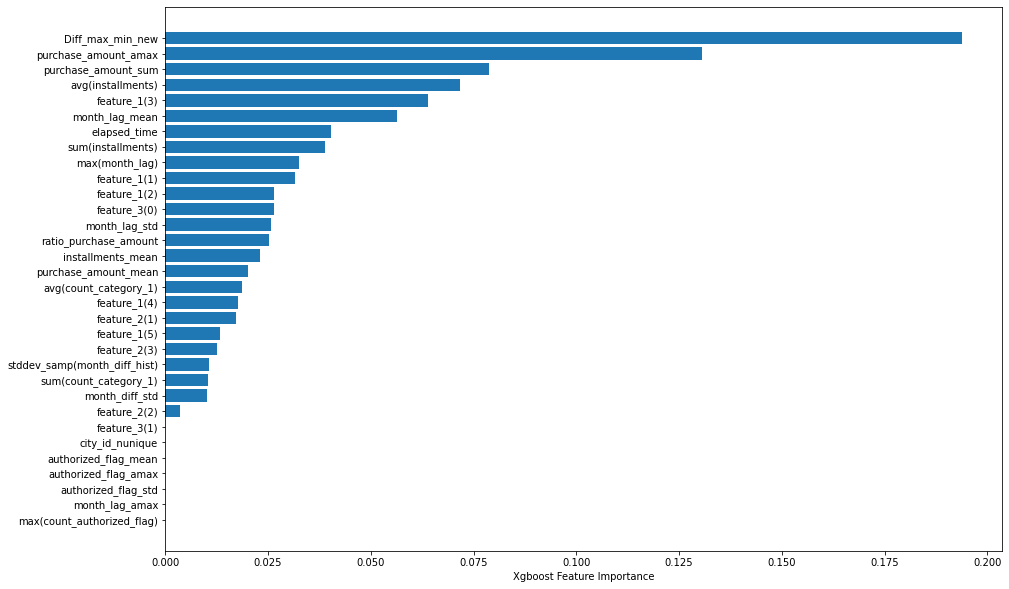

In [39]:
#LPS&OSR: Se establece el tamaño de la figura
plt.rcParams["figure.figsize"] = (15,10)
#LPS&OSR: Se instancian en una variable   la importancia de los valores obtenidos del parametro featrure_importance y se organizan de mayor a menor
sorted_idx = xgb.feature_importances_.argsort()
# LPS&OSR: Se gráfica los valores 
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [40]:
# LPS &OSR: Se concatenan dos dataframe; uno con el nombre de las columans y otro con el valor de la importancia. 
XGBRegressor_1= pd.concat([pd.DataFrame(X.columns[sorted_idx], columns=['Features']),pd.DataFrame(xgb.feature_importances_[sorted_idx],columns=['Importance'] )], axis=1)

In [41]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculados por xgboots que sean inferiores a una centésima del feature important mas alto.
XGBRegressor_1[XGBRegressor_1['Importance']<=np.max(XGBRegressor_1['Importance'])/100]  

,Features,Importance
0,max(count_authorized_flag),0.0
1,month_lag_amax,0.0
2,authorized_flag_std,0.0
3,authorized_flag_amax,0.0
4,authorized_flag_mean,0.0
5,city_id_nunique,0.0
6,feature_3(1),0.0


In [42]:
#LPS &OSR: Se instancian las features anteriores a una variable
XGBRegressor_1_features= XGBRegressor_1[XGBRegressor_1['Importance']<=np.max(XGBRegressor_1['Importance'])/100]

In [43]:
#LPS &OSR: Se imprime la longitud de las caracteristicas
len(XGBRegressor_1_features)

7

#### **3.1.1 Regresion linear (modelo base)** 




In [44]:
#LPS & OSR: Se crea una copia del DataFrame Inicial
X= ELO_DB.copy()

In [45]:
#LPS &OSR: Se convierten en lista la serie de features que se seleccionarón como menos representativas
list(XGBRegressor_1_features['Features'])

['max(count_authorized_flag)',
 'month_lag_amax',
 'authorized_flag_std',
 'authorized_flag_amax',
 'authorized_flag_mean',
 'city_id_nunique',
 'feature_3(1)']

In [46]:
#LPS &OSR: Se eliminan del dataset X las variables que fueron menos representativas según el algoritmo  Xgboots
X.drop(columns=list(XGBRegressor_1_features['Features']), inplace=True)
#LPS& OSR: Se elimina la variable target del dataset X
X.drop(columns=['target'], inplace=True) 

#LPSR &OSR: Se asigna la variable target  a la variable Y
Y= ELO_DB['target']      

#LPS&OSR: Los datos se dividen en train y trest con el 20% de datos para test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [47]:
#LPS &OSR se entrena el modelo y se obtiene los score de train empleando la función get_cv_scores
LR_Xg_1 = LinearRegression().fit(X_train, Y_train)
get_cv_scores(LR_Xg_1)

[['CV Mean: ', 0.0765612717105784], ['STD: ', 0.0003466522459899707]]

Se obtiene de la etapa de entrenamiento un R2 de 0,0765 para el modelo de regresión el cual se entrenó eliminando  las siguientes características: 

 * max(count_authorized_flag)',
 * month_lag_amax',
 * authorized_flag_std',
 * authorized_flag_amax
 * authorized_flag_mean
 * city_id_nunique
 * feature_3(1)

In [48]:
#LPS &OSR se realiza la predicción con los datos de test y se imprimen los resultados de las metricas R2 y RMSE
Y_pred_LR_Xg_1 = LR_Xg_1.predict(X_test)

print('R2',r2_score(Y_test, Y_pred_LR_Xg_1))
print('RMSE',mean_squared_error(Y_test, Y_pred_LR_Xg_1, squared=False))

R2 0.07215139120493519
RMSE 1.4703854153910678


Se obtiene un R2 de 0,072151 y un RMSE de 1,47 con el conjunto de datos de test.


In [49]:
#LPS&OSR Se crea un lista que almacenará los resultados obtenidos
XG_B= ["Xgboost",get_cv_scores(LR_Xg_1)[0][1]]
#LPS&OSR: se guardan los resultados obtenidos 
XG_B.append(r2_score(Y_test, Y_pred_LR_Xg_1))

#### **3.1.2 Decision Tree Regressor**

In [50]:
#LPS &OSR Se instancian los parametros para posteriormente hacer  la busqueda valores de parámetros específicos para un estimador
parameters={"splitter":["best"],
            "max_depth" : [None, 3,7,9,20],
            "min_samples_split":[3,7,9,40],
            "min_samples_leaf":[1,5,7,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [51]:

#LPS &OSR Se instancia el modelo DecisionTree Regressor con un randon_state=42 para obtener siempre las mismas características

reg_decision_model_FR_Xg1=DecisionTreeRegressor(random_state=42)
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
start_time = time.time()

#LPS&OSR se realiza la busqueda de hiperparámetros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia R2 como medida de evaluación 
tuning_model_FR_Xg1=GridSearchCV(reg_decision_model_FR_Xg1,param_grid=parameters,scoring='r2',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model_FR_Xg1.fit(X_train,Y_train)

Time_FR_Xg1=(time.time() - start_time)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


In [52]:
#LPS &OSR: se imprimen los mejores hiperparáametros obtenidos y el score de validación
print(tuning_model_FR_Xg1.best_params_)
print('Score de validation',tuning_model_FR_Xg1.best_score_)

{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.09331644526481953


In [53]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation.
DT_FR_Xg1_results=tuning_model_FR_Xg1.cv_results_
DT_FR_Xg1=pd.DataFrame(DT_FR_Xg1_results)#LPS &OSR: Los resultados se guardan en un dataframe
DT_FR_Xg1[DT_FR_Xg1['params']==tuning_model_FR_Xg1.best_params_]['mean_train_score']#LPS&OSR: Se filtan los mejores parametros y se implimen

296    0.114238
Name: mean_train_score, dtype: float64

Se obtiene un R2 de 0.1142 despues de realizar la busqueda de hiperpárametros en el arbol de decisión regresor.

In [54]:
#LPS&OSR: Se guardan en la variable mean_train_score_DT_FR los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score_DT_FR_Xg1=float(DT_FR_Xg1[DT_FR_Xg1['params']==tuning_model_FR_Xg1.best_params_]['mean_train_score'].values[0])

In [55]:
#LPS&OSR: Se intancia el modelo con los mejores hiperparametros
tuned_hyper_model_FR_Xg1= DecisionTreeRegressor(max_depth=None,max_features=None,max_leaf_nodes=90,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model_FR_Xg1.fit(X_train,Y_train)
y_pred_DTR_FR_Xg1=tuned_hyper_model_FR_Xg1.predict(X_test)

In [56]:
#LPS&OSR: Se imprimen los score R2 y RMSE para los datos de test
print('R2',r2_score(Y_test, y_pred_DTR_FR_Xg1))
print('RMSE',mean_squared_error(Y_test, y_pred_DTR_FR_Xg1, squared=False))

R2 0.09489244600881452
RMSE 1.4522544658033196


Para el modelo DecisionTreeRegressor se obtuvo un R2 de 0.0948 y un RSME de 1.452. 



In [57]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decisiontreeregressor
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
XG_B.append(mean_train_score_DT_FR_Xg1)
XG_B.append(r2_score(Y_test, y_pred_DTR_FR_Xg1))
XG_B.append(Time_FR_Xg1)
summary_results.append(XG_B)

### **3.2. Xgboost Permutation**

La variación con el método de permutación consiste en barajar aleatoriamente cada función y calcular el cambio en el rendimiento del modelo. Las características que más afectan el rendimiento son las más importantes.

In [58]:
#LPS &OSR:Se hace una copia del DataFrame inicial 
X= ELO_DB.copy()
#LPS &OSR: Se elimina la columna target y se asigna el dataframe a la variable X
X= X.drop(columns=['target'])
#LPS &OSR  se instancia la variable Y con la serie de la columna target 
Y= ELO_DB['target']      
#LPS &OSR  se instancia la variable Y con la serie de la columna target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [59]:
#LPS &OSR: Se intancia el modelo XGBR  regressor inicialmente con 100 arboles de decision
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, Y_train) #LPS&OSR: Se ajusta el modelo.

[12:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [60]:
#LPS &OSR: Se calcula la importancia de la permutación del modelo para el modelo Xgboots
perm_importance = permutation_importance(xgb, X_test, Y_test)

Text(0.5, 0, 'Permutation Importance')

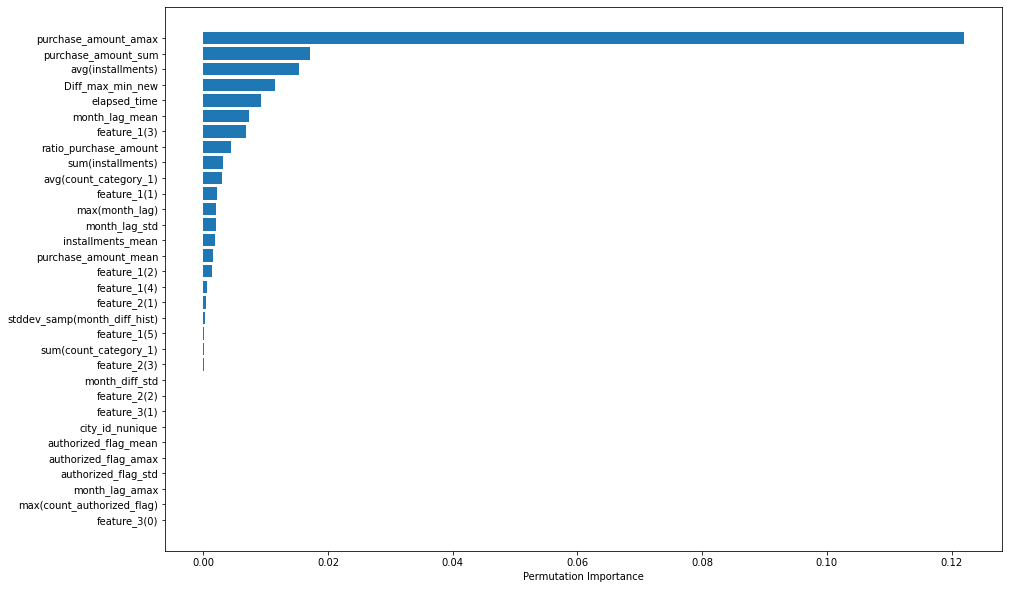

In [61]:
#LPS &OSR: Se visualiza la importancia de las variables
plt.rcParams["figure.figsize"] = (15,10)
sorted_idy = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idy], perm_importance.importances_mean[sorted_idy])
plt.xlabel("Permutation Importance")

In [62]:
#LP &OSR: Se concatenan dos DataFrame  el primero contiene el nombre de las features y el otro la importancia calculada por Xgboots permutation
XGBRegressor_2= pd.concat([pd.DataFrame(X.columns[sorted_idy], columns=['Features']),pd.DataFrame(perm_importance.importances_mean[sorted_idy],columns=['Importance'] )], axis=1)

In [63]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculada por xgboots permutation que sean inferiores a una centésima del feature important  alto.
XGBRegressor_2[XGBRegressor_2['Importance']<=np.max(XGBRegressor_2['Importance'])/100]

,Features,Importance
0,feature_3(0),-0.000002
1,max(count_authorized_flag),0.000000
2,month_lag_amax,0.000000
3,authorized_flag_std,0.000000
4,authorized_flag_amax,0.000000
5,authorized_flag_mean,0.000000
6,city_id_nunique,0.000000
7,feature_3(1),0.000000
8,feature_2(2),0.000009
9,month_diff_std,0.000011


In [64]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculada por xgboots que sean inferiores a una centésima del feature important mas alto.
XGBRegressor_2_features=XGBRegressor_2[XGBRegressor_2['Importance']<=np.max(XGBRegressor_2['Importance'])/100]

In [65]:
#LPS &OSR:Se calcula la cantidad de features seleccionadas por su baja importanica
len(XGBRegressor_2_features)

16

#### **3.2.1 Regresion linear (modelo base)**

In [66]:
#LPS &OSR Se hace una copia del DataFrame inicial 
X= ELO_DB.copy()

In [67]:
#LPS &OSR: Se convierten en lista la serie de features que se seleccionarón como menos representativas.
list(XGBRegressor_2_features['Features'])

['feature_3(0)',
 'max(count_authorized_flag)',
 'month_lag_amax',
 'authorized_flag_std',
 'authorized_flag_amax',
 'authorized_flag_mean',
 'city_id_nunique',
 'feature_3(1)',
 'feature_2(2)',
 'month_diff_std',
 'feature_2(3)',
 'sum(count_category_1)',
 'feature_1(5)',
 'stddev_samp(month_diff_hist)',
 'feature_2(1)',
 'feature_1(4)']

In [68]:
#LPS &OSR: Se eliminan del dataset X las variables que fueron menos representativas según el algoritmo  Xgboots permutation
X.drop(columns=list(XGBRegressor_2_features['Features']), inplace=True)
#LPS& OSR: Se elimina la variable target del dataset X
X.drop(columns=['target'], inplace=True) 
#LPSR &OSR: Se asigna la variable target  a la variable Y
Y= ELO_DB['target']      
# LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [69]:
#LPS &OSR se entrena el modelo y se obtiene los score de train empleando la función get_cv_scores
LR_Xg_2 = LinearRegression().fit(X_train, Y_train)
get_cv_scores(LR_Xg_2)

[['CV Mean: ', 0.07514454370813395], ['STD: ', 0.00029747254739236404]]

Se obtiene de la etapa de entrenamiento un R2 de 0,0704 para el modelo de regresión el cual se entrenó eliminando las siguientes características:

 * month_diff_std
 * max(count_authorized_flag)
 * month_lag_amax
 * authorized_flag_std
 * authorized_flag_amax
 * authorized_flag_mean
 * city_id_nunique
 * feature_3(1)
 * feature_2(2)
 * feature_3(0)
 * feature_2(3)
 * sum(count_category_1)
 * feature_1(5)
 * stddev_samp(month_diff_hist)
 * feature_2(1)
 * feature_1(4)

In [70]:
#LPS &OSR se realiza la predicción con los datos de test y se imprimen los resultados de las métricas R2 y RMSE
Y_pred_LR_Xg_2 = LR_Xg_2.predict(X_test)

print('R2',r2_score(Y_test, Y_pred_LR_Xg_2))
print('RMSE',mean_squared_error(Y_test, Y_pred_LR_Xg_2, squared=False))

R2 0.07040010480741044
RMSE 1.4717724153866132


Se obtiene un R2 de 0,070 y un RMSE de 1,47 con el conjunto de datos de test.

In [71]:
#LPS&OSR: se guardan los resultados obtenidos
XG_B_PER= ["Xgboost Permutation",get_cv_scores(LR_Xg_2)[0][1]]
XG_B_PER.append(r2_score(Y_test, Y_pred_LR_Xg_2))

#### **3.2.2 Decision Tree Regressor**

In [72]:
#LPS &OSR Se instancian los parametros para posteriormente hacer  la busqueda valores de parámetros específicos para un estimador
parameters={"splitter":["best"],
            "max_depth" : [None, 3,7,9,20],
            "min_samples_split":[3,7,9,40],
            "min_samples_leaf":[1,5,7,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [73]:
#LPS &OSR Se instancia el modelo DecisionTree Regressor con un randon_state=42 para obtener siempre las mismas caracteristicas

reg_decision_model_FR_Xg2=DecisionTreeRegressor(random_state=42)
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
start_time = time.time()
#LPS&OSR se realiza la busqueda de hiperparametros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia R2 como medida de evaluación 
tuning_model_FR_Xg2=GridSearchCV(reg_decision_model_FR_Xg2,param_grid=parameters,scoring='r2',cv=Kf,verbose=3,  n_jobs=-1, return_train_score=True)
tuning_model_FR_Xg2.fit(X_train,Y_train)

Time_FR_Xg2=(time.time() - start_time)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


In [74]:
#LPS &OSR: se imprimen los mejores parámetros obtenidos y el score de validación
print(tuning_model_FR_Xg2.best_params_)
print('Score de validation',tuning_model_FR_Xg2.best_score_)

{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.09409293968450046


In [75]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation.
DT_FR_Xg2_results=tuning_model_FR_Xg2.cv_results_
DT_FR_Xg2=pd.DataFrame(DT_FR_Xg2_results)
DT_FR_Xg2[DT_FR_Xg2['params']==tuning_model_FR_Xg2.best_params_]['mean_train_score']

296    0.11399
Name: mean_train_score, dtype: float64

Se obtiene un R2 de 0.1139 despues de realizar la busqueda de hiperpárametros en el modelo TreeDecisionRegressor. 

In [76]:
#LPS&OSR: Se guardan en la variable mean_train_score_DT_Xg2 los resultados obtenidos con la mejor combinación de hiperparámetros
mean_train_score_DT_FR_Xg2=float(DT_FR_Xg2[DT_FR_Xg2['params']==tuning_model_FR_Xg2.best_params_]['mean_train_score'].values[0])

In [77]:
#LPS&OSR: Se intancia el modelo con los mejores hiperpárametros y se hace una predicción con los datos de test
tuned_hyper_model_FR_Xg2= DecisionTreeRegressor(max_depth=None,max_features=None,max_leaf_nodes=90,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model_FR_Xg2.fit(X_train,Y_train)
y_pred_DTR_FR_Xg2=tuned_hyper_model_FR_Xg2.predict(X_test)

In [78]:
#LPS&OSR: Se imprimen los score R2 y RMSE para los datos de test
print('R2',r2_score(Y_test, y_pred_DTR_FR_Xg2))
print('RMSE',mean_squared_error(Y_test, y_pred_DTR_FR_Xg2, squared=False))

R2 0.09219176022451292
RMSE 1.4544194911777373


Para el modelo DecisionTreeRegressor se obtuvo un R2 de 0.0921 y un RSME de 1.454.

In [79]:
#LPS &OSR: Se guardan los datos obtenidos en el modelo decisiontreeregressor
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
XG_B_PER.append(mean_train_score_DT_FR_Xg2)
XG_B_PER.append(r2_score(Y_test, y_pred_DTR_FR_Xg2))
XG_B_PER.append(Time_FR_Xg2)
summary_results.append(XG_B_PER)

### **3.3. Xgboost Shap**

El método Shap emplea los valores de Shapley de la teoría de juegos para estimar la importancia de cada caracteristica. 

In [80]:
#LPS &OSR Se hace una copia del DataFrame inicial 
X= ELO_DB.copy()
#LPS &OSR  se instancia la variable Y con la serie de la columna target
X= X.drop(columns=['target']) 
Y= ELO_DB['target']      
#LPS &OSR  se instancia la variable Y con la serie de la columna target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [81]:
#LPS &OSR: Se intancia el modelo XGBR  regressor inicialmente con 100 arboles de decisión
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, Y_train) #LPS&OSR: Se ajusta el modelo.

[13:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [82]:
#LPS OSR: Se efectua la estimación con el algoritmo shap para evaluar la contribución cada característica a la predicción.
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

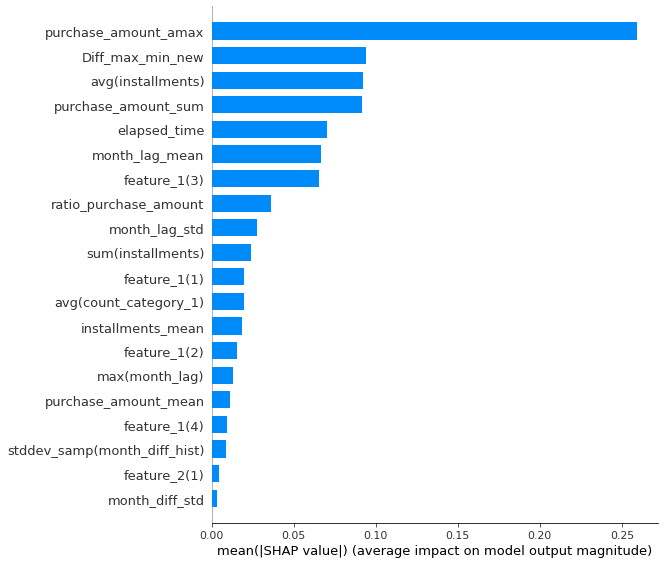

In [83]:
#LPS&OSR resumen
shap.summary_plot(shap_values, X_test, plot_type="bar")

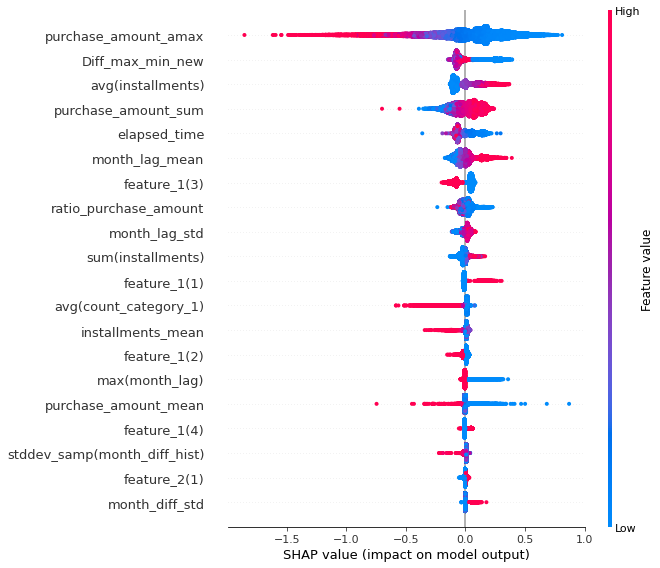

In [84]:
#LPS &OSR: Se gráfica la importancia de las caracteristicas, teniendo en cuenta el rango de impacto en el modelo. 
shap.summary_plot(shap_values, X_test)

In [85]:
#LPS &OSR: Se concatenan dos dataframe  el primero contiene el nombre de las features y el otro la importancia calculada por Xgboots permutation
XGBRegressor_3= pd.concat([pd.DataFrame(X.columns, columns=['Features']),pd.DataFrame(np.mean(np.abs(pd.DataFrame(shap_values)),axis=0),columns=['Importance'] )], axis=1)

In [86]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculada por xgboots shap que sean inferiores a una centésima del feature important mas alto.
XGBRegressor_3[XGBRegressor_3['Importance']<=np.max(XGBRegressor_3['Importance'])/100]

,Features,Importance
0,max(count_authorized_flag),0.000000
7,city_id_nunique,0.000000
8,authorized_flag_mean,0.000000
9,authorized_flag_amax,0.000000
10,authorized_flag_std,0.000000
16,month_lag_amax,0.000000
26,feature_1(5),0.001664
28,feature_2(2),0.000350
29,feature_2(3),0.001093
30,feature_3(0),0.002451


In [87]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculada por xgboots que sean inferiores a una centésima del feature important mas alto.
XGBRegressor_3_features=XGBRegressor_3[XGBRegressor_3['Importance']<=np.max(XGBRegressor_3['Importance'])/100]

In [88]:
#LPS &OSR:Se calcula la cantidad de features seleccionadas por su baja importanica
len(XGBRegressor_3_features)

11

#### **3.3.1 Regresion linear (modelo base**) 

In [89]:
#LPS &OSR Se hace una copia del DataFrame inicial
X= ELO_DB.copy()

In [90]:
#LPS &OSR: Se convierten en lista la serie de features que se seleccionaron como menos representativas
list(XGBRegressor_3_features['Features'])

['max(count_authorized_flag)',
 'city_id_nunique',
 'authorized_flag_mean',
 'authorized_flag_amax',
 'authorized_flag_std',
 'month_lag_amax',
 'feature_1(5)',
 'feature_2(2)',
 'feature_2(3)',
 'feature_3(0)',
 'feature_3(1)']

In [91]:
#LPS &OSR: Se eliminan del dataset X las variables que fueron menos representativas según el algoritmo  Xgboots shap
X.drop(columns=list(XGBRegressor_3_features['Features']), inplace=True)
#LPS& OSR: Se elimina la variable target del dataset X
X.drop(columns=['target'], inplace=True) 
#LPSR &OSR: Se asigna la variable target  a la variable Y
Y= ELO_DB['target']      
# LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [92]:
#LPS &OSR se entrena el modelo y se obtiene los score de train empleando la función get_cv_scores
LR_Xg_3 = LinearRegression().fit(X_train, Y_train)
get_cv_scores(LR_Xg_3)

[['CV Mean: ', 0.07655883897003794], ['STD: ', 0.0003675491105986276]]

Se obtiene de la etapa de entrenamiento un R2 de 0,0765 para el modelo de regresión el cual se entrenó eliminando las siguientes características:

  * max(count_authorized_flag)
  * city_id_nunique
  * authorized_flag_mean
  * authorized_flag_amax
  * authorized_flag_std
  * month_lag_amax
  * feature_1(5)
  * feature_2(2)
  * feature_2(3)
  * feature_3(0)
  * feature_3(1)

In [93]:
#LPS &OSR se realiza la predicción con los datos de test y se imprimen los resultados de las metricas R2 y RMSE
Y_pred_LR_Xg_3 = LR_Xg_3.predict(X_test)

print('R2',r2_score(Y_test, Y_pred_LR_Xg_3))
print('RMSE',mean_squared_error(Y_test, Y_pred_LR_Xg_3, squared=False))

R2 0.0721610114162935
RMSE 1.4703777926738453


Se obtiene un R2 de 0,0721 y un RMSE de 1,4703 con el conjunto de datos de test. Se evidencia que los resultados obtenidos en train y en test tienen valores muy similares. 

In [94]:
#LPS&OSR Se crea un lista que almacenará los resultados obtenidos
XG_B_SHAP= ["Xgboost SHAP",get_cv_scores(LR_Xg_3)[0][1]]
XG_B_SHAP.append(r2_score(Y_test, Y_pred_LR_Xg_3))

#### **3.3.2 Decision Tree Regressor**

In [95]:
#LPS &OSR Se instancian los parametros para posteriormente hacer  la busqueda valores de parámetros específicos para un estimador 

parameters={"splitter":["best"],
            "max_depth" : [None, 3,7,9,20],
            "min_samples_split":[3,7,9,40],
            "min_samples_leaf":[1,5,7,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [96]:
#%%time
#LPS &OSR Se instancia el modelo DecisionTree Regressor con un randon_state=42 para obtener siempre las mismas caracteristicas
reg_decision_model_FR_Xg3=DecisionTreeRegressor(random_state=42)
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
start_time = time.time()
#LPS&OSR se realiza la busqueda de hiperparametros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia R2 como medida de evaluación 
tuning_model_FR_Xg3=GridSearchCV(reg_decision_model_FR_Xg3,param_grid=parameters,scoring='r2',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model_FR_Xg3.fit(X_train,Y_train)

Time_FR_Xg3=(time.time() - start_time)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


In [97]:
#LPS &OSR: se imprimen los mejores parametros obtenidos y el score de validación
print(tuning_model_FR_Xg3.best_params_)
print('Score de validation',tuning_model_FR_Xg3.best_score_)

{'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.09328538330891882


In [98]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation.
DT_FR_Xg3_results=tuning_model_FR_Xg3.cv_results_
DT_FR_Xg3=pd.DataFrame(DT_FR_Xg3_results)
DT_FR_Xg3[DT_FR_Xg3['params']==tuning_model_FR_Xg3.best_params_]['mean_train_score']

1196    0.114133
Name: mean_train_score, dtype: float64

In [99]:
#LPS&OSR: Se guardan en la variable mean_train_score_DT_Xg3 los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score_DT_FR_Xg3=float(DT_FR_Xg3[DT_FR_Xg3['params']==tuning_model_FR_Xg3.best_params_]['mean_train_score'].values[0])

In [100]:
#LPS&OSR: Se intancia el modelo con los mejores hiperparametros y se hace una predicción con los datos de test
tuned_hyper_model_FR_Xg3= DecisionTreeRegressor(max_depth=9,max_features=None,max_leaf_nodes=90,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model_FR_Xg3.fit(X_train,Y_train)
y_pred_DTR_FR_Xg3=tuned_hyper_model_FR_Xg3.predict(X_test)

In [101]:
#LPS&OSR: Se imprimen los score R2 y RMSE para los datos de test
print('R2',r2_score(Y_test, y_pred_DTR_FR_Xg3))
print('RMSE',mean_squared_error(Y_test, y_pred_DTR_FR_Xg3, squared=False))

R2 0.094831549853443
RMSE 1.4523033192383232


Para el modelo DecisionTreeRegressor se obtuvo un R2 de 0.0948 y un RSME de 1.452

No se distingue una diferencia significativa con respecto al dataset completo.

In [102]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decisiontreeregressor
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
XG_B_SHAP.append(mean_train_score_DT_FR_Xg3)
XG_B_SHAP.append(r2_score(Y_test, y_pred_DTR_FR_Xg3))
XG_B_SHAP.append(Time_FR_Xg3)
summary_results.append(XG_B_SHAP)

## **Resumen**

In [103]:
#LPS&OSR: Se crea una lista con los nombres del dataset que se construira con el Dataframe Resumen
Columnas=["Tecnica de reduccion", "RL R2_Train", "RL R2_Test",  "DTR R2_Train", "DTR R2_Test", "Time_G_Search"]
#LPS&OSR: Se crea el dataframe resumen con las listas guardadas anteriormente en summary_results.
Resumen= pd.DataFrame(summary_results, columns=Columnas)
Resumen

,Tecnica de reduccion,RL R2_Train,RL R2_Test,DTR R2_Train,DTR R2_Test,Time_G_Search
0,Full data frame,0.081110,0.078017,0.114238,0.094892,596.209131
1,Row reduction,0.082662,0.078586,0.119028,0.095496,293.934148
2,Xgboost,0.076561,0.072151,0.114238,0.094892,580.404939
3,Xgboost Permutation,0.075145,0.070400,0.113990,0.092192,500.315473
4,Xgboost SHAP,0.076559,0.072161,0.114133,0.094832,540.352809


Se logró uno de los objetivos planteados en esta etapa, el cual consistía en verificar la forma como respondía los datasets resultantes de las modalidades de reducción de dimensionalidad en un modelo de machine Learning más complejo. En el caso de la tarea de regresión, se observa que si bien los valores de las métricas de Machine Learning (R2) son bajos tanto para la regresión lineal como para el Decision Tree Regressor optimizado, ese último obtuvo un valor superior en el R2, la cual es una métrica que se busca maximizar. 


Si bien los resultados obtenidos por medio del Decision Tree Regressor son más elevados al compararse con los de la regresión lineal, no existe una gran variabilidad entre los resultados obtenidos por el primero. Esto implica que el rendimiento del modelo no será necesariamente el único criterio de elección para determinar si se selecciona una técnica de reducción o si se conserva el full dataset. En este caso se considerará igualmente los resultados del tiempo de ejecución. 

El hecho de implementar una de las modalidades de reducción definidas (reducción por filas o reducción por columnas), no penaliza necesariamente el rendimiento del modelo, dado que al compararse los resultados del rendimiento obtenido para cada una de estas modalidades de reducción con el rendimiento de la base de datos completa (Full Dataset), no existe una disminución significativa en las métricas de Machine Learning (R2).

Por las razones explicadas previamente, se decide implementar una técnica de reducción de dimensionalidad al considerarse que la supresión de la información en la base de datos no repercute negativamente en el rendimiento del modelo ajustado. En este sentido, a R2 en fase de test aproximadamente constate, se seleccionada como mejor técnica de reducción de dimensionalidad, la reducción por columnas considerando las características irrelevantes encontradas por el método permutation importance. Si bien, no es necesariamente la técnica que minimiza los tiempos de entrenamiento, si es la que logra el mejor compromiso entre la maximización de la cantidad de información relevante dentro de la base de datos y la minimización de los tiempos de ejecución, siendo esta, la segunda más baja dentro de las iteraciones realizadas.


##  **4. Seleccion de la base de datos**

Como se menciono anteriormente, se eliminarán las caracteristicas menos importantes encontradas a través del algoritmo Xgboost Permutation. 

**Xgboost Permutation**

In [104]:
#LPS &OSR: Se realiza una copia del dataset inicial
ELO_DB_VF= ELO_DB.copy()
#LPS &OSR: Se asignana a una lista las caracteristicas menos importantes.
list(XGBRegressor_2_features['Features'])

#LPS &OSR: Se eliminan las caracteristicas con menor importancia.
ELO_DB_VF.drop(columns=list(XGBRegressor_2_features['Features']), inplace=True)

In [105]:
#LPS &OSR :Se comprueba que el dataset tiene las caracteristicas mas importantes. 
ELO_DB_VF

,avg(count_category_1),avg(installments),sum(installments),max(month_lag),purchase_amount_mean,purchase_amount_amax,purchase_amount_sum,installments_mean,month_lag_mean,month_lag_std,elapsed_time,Diff_max_min_new,ratio_purchase_amount,feature_1(1),feature_1(2),feature_1(3),target
0,-0.484760,-0.770803,-0.588104,-1.675451,-0.308627,-0.382937,0.452051,-0.694257,1.606217,-1.959186,-0.324967,-0.532158,0.015966,0.0,0.0,1.0,-0.078485
1,0.030289,1.436304,0.180519,0.244507,0.941447,0.664175,0.400252,0.259869,1.299888,-0.465971,-0.014008,0.373949,-0.050793,1.0,0.0,0.0,0.014108
2,-0.448208,-0.764929,-0.578497,-1.675451,-0.386942,-0.378418,0.262464,-0.694257,0.074571,0.767039,0.520561,1.129039,-0.029036,0.0,0.0,1.0,1.063681
3,-0.484760,-0.770803,-0.588104,0.244507,-0.345920,-0.276500,-3.036007,-0.694257,0.457482,0.375990,-0.111838,1.280057,-0.018901,0.0,1.0,0.0,-1.530249
4,-0.355998,0.201704,-0.136538,0.244507,-0.299822,-0.117087,-0.515463,0.471897,1.606217,-1.959186,-1.072665,-0.481819,0.009096,0.0,1.0,0.0,1.293800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167753,-0.440498,-0.685450,-0.472811,0.244507,-0.278173,-0.089502,-0.338797,-0.694257,-1.074164,-0.289721,0.415744,0.373949,-0.020937,0.0,1.0,0.0,-1.135256
167754,-0.484760,0.227735,-0.261439,0.244507,-0.353288,-0.316813,-0.224678,0.532476,1.168604,-0.174453,-1.072665,0.222931,0.013278,0.0,1.0,0.0,-1.200510
167755,-0.484760,1.381126,0.161304,0.244507,-0.291993,-0.248442,0.295428,-0.455725,0.074571,0.767039,-0.646407,-0.381140,-0.004364,0.0,1.0,0.0,-1.194355
167756,4.708646,-0.012110,-0.492026,0.244507,0.258874,-0.222434,0.826105,-1.648383,-1.457075,0.401794,-0.967847,-1.488605,-0.021396,0.0,1.0,0.0,1.148358


In [106]:
#LPS &OSR: Se convierte a formato csv el dataframe resultante y se nombre 02_DB.cvs
ELO_DB_VF.to_csv("02_DB.csv")

In [107]:
#LPS&OSr: se comprime el archivo csv. 
ELO_DB_VF.to_csv('02_DB.gz', compression='gzip')

# **Modelados de Regresión**

En esta sección se desarrollará el modelado de la tarea de regresión. Inicialmente los modelos fueron sometidos a dos fases sucesivas para determinar los parametros óptimos a implementar y asi optimizar las métricas de Machine learning  definidas para los modelos de regresión. 

La metodología se puede resumir en las  siguientes etapas:

1.**Búsqueda aleatoria de hiperparámetros en un rango amplio de valores**

Esta etapa se emplea un RandomizedSerchCV el cual muestrea un número fijo de configuraciones de parámetros de las distribuciones especificadas, este proceso permiter evaluar dentro un conjunto amplio de hiperpáametros el valor que mejor se ajusta a los datos. Este dato será el input para la fase 2. 

2.**Búsqueda exhaustiva de hiperparámetros acotados**

En esta etapa se emplean técnicas de validación cruzada con el objetivo de encontrar el valor óptimo de los hiperpárametros, delimitando la busqueda a valores dentro un rango cercano al valor obtendio en la etapa 1

3.**Contrucción y ajuste de los modelos de regresión**

En los modelos de regresión, se pueden identificar dos tipos de estrategia: la primera es el ajuste de los modelos simples optimizados a partir de la búsqueda de hiperparámetros, y la segunda estrategia es la utilización de métodos de ensemble considerando como estimador base a los algoritmos simples que mejores resultados obtuvieron previamente, partiendo de esta manera de los métodos más sencillos hasta los más complejos.





## **Descarga de paquetes**

In [108]:
#LRS &OSR Descarga de paquetes
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#clasificaciòn
from sklearn.linear_model import LogisticRegression

In [109]:
!git clone https://github.com/LuisPortela/ELO.git #LPS & OSR: se clona el repostorio que alberga el documento json para hacer la lectura de datos directamente 
import zipfile                                     #           del API de kaggel
import os
import pandas as pd
os.environ['KAGGLE_CONFIG_DIR'] = "/content/ELO"

fatal: destination path 'ELO' already exists and is not an empty directory.


**Carga del dataset**

In [110]:
#LPS &OSR: Se realiza la lectura del archivo 02_DB.gz
ELO_DB = pd.read_csv('ELO/02_DB.gz', compression='gzip', header=0, sep=',')

In [111]:
#LPS & OSR: Se elimina la columna  "unnamed:0" obtenida por defecto
ELO_DB.drop(columns=['Unnamed: 0'], inplace=True)

In [112]:
#LPS&OSR Visualización de las dos primeras filas del dataset
ELO_DB.head(2)

,avg(count_category_1),avg(installments),sum(installments),max(month_lag),purchase_amount_mean,purchase_amount_amax,purchase_amount_sum,installments_mean,month_lag_mean,month_lag_std,elapsed_time,Diff_max_min_new,ratio_purchase_amount,feature_1(1),feature_1(2),feature_1(3),target
0,-0.484760,-0.770803,-0.588104,-1.675451,-0.308627,-0.382937,0.452051,-0.694257,1.606217,-1.959186,-0.324967,-0.532158,0.015966,0.0,0.0,1.0,-0.078485
1,0.030289,1.436304,0.180519,0.244507,0.941447,0.664175,0.400252,0.259869,1.299888,-0.465971,-0.014008,0.373949,-0.050793,1.0,0.0,0.0,0.014108


In [113]:
# LPS &OSR se crea la function to get_cv_scores
#LPS&OSR: esta función calcula el promedio de valores R2 del CV
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             Y_train,
                             cv=3,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))

In [114]:
# LPS &OSR se crea la function to get_cv_scores_quadratic
#LPS&OSR: esta función calcula el promedio de valores R2 del CV
def get_cv_scores_Quadratic(model):
    scores = cross_val_score(model,
                             X_train_,
                             Y_train,
                             cv=3,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))

La estrategia de validación cruzada fue **Kfold**, en este caso se decide dividir la data en 3 folds. 

In [115]:
#LPS&OSR: Se define la estrategía de valización cruzada con k=3
Kf= KFold(n_splits=3) 

In [116]:
#LPS &OSR Se hace una copia del DataFrame inicial 
#LPS &OSR Se elimina la columna target y se asigna el dataframe a la variable X
#LPS &OSR Se instancia la variable Y con la serie de la columna target   
#LPS&OSR: Los datos se dividen en train y trest con el 20% de datos para test. 
X= ELO_DB.copy()
X= X.drop(columns=['target']) 
Y= ELO_DB['target']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

## **1. Modelos simples para regresión**

En esta etapa se evaluarán modelos de regresión con el objetivo de predecir la variable objetivo target (Fidelización), en este sentido, a cada modelo se realizará una busqueda y ajuster de los mejores hiperparámetros. 

Los modelos que se evaluarán son los siguientes: 

1. Regresión  lineal
  - Rige regressión
  - Lasso Regression
  - Elastic-Net Regression
2. Polynomial Regression Degree=2
3. Decision Tree Regresor
4. Random Forest





### **1.1 Linear Regression** 

#### **1.1.1  Regresion linear (modelo base)**

In [117]:
# LPS &OSR se instancia y se justa el modelo
#LPS&OSRse obtiene los score de train empleando la función get_cv_scores
LR = LinearRegression().fit(X_train, Y_train)
get_cv_scores(LR) 

CV Mean:  0.0751445437081339
STD:  0.0002974725473923978


In [118]:
#LPS &OSR se realiza la predición con los datos de test y se imprimen los resultados de las metricas R2 y RMSE
Y_pred_LR = LR.predict(X_test)

print('R2',r2_score(Y_test, Y_pred_LR))
print('RMSE',mean_squared_error(Y_test, Y_pred_LR, squared=False))

R2 0.07040010480741044
RMSE 1.4717724153866132


Para el modelo de regresión lineal simple se obtiene un R2 0,075 para train  y  0,070 para test. 

**Modelos regularizados**

Los métodos regularizadados de esta sección emplean métodos que presionan a que los coeficientes del modelo tiendan a cero, minimizando el overfitting, reducciendo la varianza y reduciendo en el modelo los predictores con menor importancia. 

los métodos de regularización que se utilizarán en esta etapa son:
* Ridge
* Lasso
* Elastic Net con Python

#### **1.1.2 Ridge Regression (L2 Regularization)**

Este modelo resuelve un modelo de regresión donde la función de pérdida es la función lineal de mínimos cuadrados y la regularización viene dada por la norma L2.
 Adicionalmente este método tiene la ventaja de ser capaz de reducir varianza.

Siguiendo la metología anteriormente explicada se realiza incialmente la búsqueda aleatoria de hiperparámetros en un rango amplio de valores para encoentrar el alpha, seguido  a esto, se realiza la busqueda exhaustiva de hiperparámetros acotados en la etapa 1 para el mismo parámetro. 



##### **Random hyperparameters**

In [119]:
#LPS&OSR: se instancia en la  varible  alpha un rango de valores entre 0.001 y 1000, en total 1000 valores.
alpha = [int(x) for x in np.linspace(start = 0.001, stop = 1000, num = 1000)]
random_grid = {'alpha': alpha}

In [120]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia lso estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros. 
Ridge_random = Ridge()
Ridge_random = RandomizedSearchCV(estimator = Ridge_random, param_distributions = random_grid, n_iter = 100, cv = Kf, verbose=2, random_state=42, n_jobs = -1)
Ridge_random.fit(X_train, Y_train)
Ridge_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'alpha': 139}

Según el proceso de búsqueda aleatoria de hiperparámetros, se encuentra que el valor del alpha óptimo para el modelo de regresión esta en un rango cercano a 139. 

##### **Hyperparameter Tuning**

In [121]:
#LPS&OSR: se instancia el modelo
ridge = Ridge(random_state=42)

In [122]:
#LPS&OSR:se instancia en una varible un rango de valores entre 120 y 150, en total 100 valores
alpha = [int(x) for x in np.linspace(start = 120, stop = 150, num = 100)]

In [123]:
#LPS&OSR: Se instancia los parametrós en un diccionario con los posibles valores de alpha
#LPS&OSR: Se crea instancia el GridserchCV, con el estimador rigde, score:R2,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros
#LPS&OSR: Se imprimen los mejores parámetros. 
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', cv = Kf, verbose=1, n_jobs=-1, return_train_score=True)
grid_result = grid.fit(X_train, Y_train)
print('Score de validation: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Score de validation:  0.0751468353496874
Best Params:  {'alpha': 144}


A partir de la busqueda de parámetros exhaustivo se encuentra que un alpha: 144 es valor que mejor se ajusta. 

In [124]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score
Ridge_results=grid_result.cv_results_
df=pd.DataFrame(Ridge_results)
df[df['params']==grid_result.best_params_]['mean_train_score']

80    0.075891
81    0.075891
82    0.075891
Name: mean_train_score, dtype: float64

In [125]:
#LPS&OSR: se instancia el modelo con los mejores parámetros y se ajusta. 
#LPS&OSR: se hace una predicción con los valores de X_test

ridge_GS = Ridge(alpha=grid_result.best_params_['alpha']).fit(X_train, Y_train)
Y_pred_ridge = ridge_GS.predict(X_test)

In [126]:
#LPS &OSR: se imprimen los valores de test
print('R2',r2_score(Y_test, Y_pred_ridge))
print('RMSE',mean_squared_error(Y_test, Y_pred_ridge, squared=False))

R2 0.07042280782579935
RMSE 1.4717544432028833


Para el modelo de regresión lineal simple se obtiene un R2 0,0758 para train 0,0751 para validation  y 0,0704 para test. 

#### **1.1.3 Lasso Regression (L1 Regularization)**

La  regularización Lasso penaliza la suma del valor absolutos de los coeficientes de regresión  a esta penalización se le conoce como L1. 

En esta etapa se realiza según la metodología planteada,  la búsqueda aleatoria de hiperparámetros en un rango amplio de valores para encoentrar el alpha, seguido  a esto, se realiza la busqueda exhaustiva de hiperparámetros acotados en la etapa 1 para el mismo parámetro.

##### **Random hyperparameters**

In [127]:
#LPS&OSR: se instancia la variable alpha un rango de valores entre 0.001 y 1000, en total 1000 valores.
alpha = [int(x) for x in np.linspace(start = 0.001, stop = 1000, num = 1000)]
random_grid = {'alpha': alpha}

In [128]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia lso estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
Lasso_random = Lasso(random_state=0)
Lasso_random = RandomizedSearchCV(estimator = Lasso_random, param_distributions = random_grid, n_iter = 100, cv = Kf, verbose=2, random_state=42, n_jobs = -1)
Lasso_random.fit(X_train, Y_train)
Lasso_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'alpha': 521}

Según el proceso de búsqueda aleatoria de hiperparámetros, se encuentra que el valor del alpha óptimo para el modelo de regresión se encuentra en un rango cercano a 521.

##### **Hyperparameter Tuning**

In [129]:
#LPS&OSR: se instancia el modelo
lasso = Lasso(random_state=42)

In [130]:
#LPS&OSR:se instancia en una varible un rango de valores entre 500 y 700, en total 100 valores
#LPS&OSR: Se instancia los parametrós en un diccionario con los posibles valores de alpha
#LPS&OSR: Se crea instancia el GridserchCV, con el estimador lasso, score:R2,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros
#LPS&OSR: Se imprimen los mejores parámetros.
alpha = [int(x) for x in np.linspace(start = 500, stop = 700, num = 100)]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', cv = Kf, verbose=2, n_jobs=-1, return_train_score=True)
grid_result = grid.fit(X_train, Y_train)

print('Score de validation: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Score de validation:  -2.85815986766913e-06
Best Params:  {'alpha': 500}


A partir de la busqueda de parámetros exhaustivo se encuentra que un alpha: 500 es valor que mejor se ajusta. 

In [131]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score
Lasso_results=grid_result.cv_results_
df=pd.DataFrame(Lasso_results)
df[df['params']==grid_result.best_params_]['mean_train_score']

0    0.0
Name: mean_train_score, dtype: float64

In [132]:
#LPS&OSR: se instancia el modelo con los mejores parámetros y se ajusta. 
#LPS&OSR: se hace una predicción con los valores de X_test
lasso_GS = Ridge(alpha=grid_result.best_params_['alpha']).fit(X_train, Y_train)
Y_pred_lasso = lasso_GS.predict(X_test)

In [133]:
#LPS &OSR: se imprimen los valores de test
print('R2',r2_score(Y_test, Y_pred_lasso))
print('RMSE',mean_squared_error(Y_test, Y_pred_lasso, squared=False))

R2 0.07046701005748024
RMSE 1.4717194511630636


Para el modelo de regresión lineal simple se obtiene un R2 0 para train, -2,85 para validation  y 0,0704 para test. 

####**1.1.4 Elastic-Net Regression**

Eastic net es un método el cual  incluye una regularización que combina la penalización L1 y L2.

Se realiza la búsqueda aleatoria de hiperparámetros en un rango amplio de valores para encoentrar el alpha y el l1_ratio, seguido a esto, se realiza la busqueda exhaustiva de hiperparámetros acotados en la etapa 1 para el mismo parámetro

##### **Random hyperparameters**

In [134]:
#LPS&OSR: se instancia en la  varible  alpha un rango de valores entre 0.001 y 1000, en total 1000 valores.
#LPS&OSR: se instancia en la  varible  l1_ratio un rango de valores entre 0.001 y 1000, en total 1000 valores.
alpha = [int(x) for x in np.linspace(start = 0.001, stop = 1000, num = 1000)]
l1_ratio = [int(x) for x in np.linspace(start = 0.001, stop = 1, num = 1000)]

#LPS&OSR: se guardan las listas en un diccionario. 
random_grid = {'alpha': alpha, 
               'l1_ratio': l1_ratio}

In [135]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia en la validación,los estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
ElasticNet_random = ElasticNet()
ElasticNet_random = RandomizedSearchCV(estimator = ElasticNet_random, param_distributions = random_grid, n_iter = 100, cv = Kf, verbose=2, random_state=42, n_jobs = -1)
ElasticNet_random.fit(X_train, Y_train)
ElasticNet_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e+05, tolerance: 3.056e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


{'alpha': 41, 'l1_ratio': 0}

Según el proceso de búsqueda aleatoria de hiperparámetros, se encuentra que el valor del alpha y el l1_ratio  son 41 y 0 respectivamente. 

##### **Hyperparameter Tuning**

In [136]:
#LPS&OSR: se instancia el modelo
Elastic_Net = ElasticNet(random_state=42)

In [137]:
#LPS&OSR:se instancia en la variable alpha un rango de valores entre 500 y 700, en total 100 valores
#LPS&OSR:se instancia en la variable l1_ratio un rango de valores entre 0.001 y 0.1, en total 100 valores
#LPS&OSR: Se instancia los parametrós en un diccionario con los posibles valores de alpha
#LPS&OSR: Se crea instancia el GridserchCV, con el estimador elastic_net, score:R2,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros
#LPS&OSR: Se imprimen los mejores parámetros.
alpha = [int(x) for x in np.linspace(start = 35, stop = 50, num = 25)]
l1_ratio = [int(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 10)]

param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(estimator=Elastic_Net, param_grid=param_grid, scoring='r2', cv = Kf, verbose=1, n_jobs=-1, return_train_score=True)
grid_result = grid.fit(X_train, Y_train)

print('Score de validation: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
Score de validation:  0.004672327794686219
Best Params:  {'alpha': 35, 'l1_ratio': 0}


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+05, tolerance: 3.056e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


A partir de la busqueda de parámetros exhaustiva se encuentra que un alpha igual 34  y un l1_ratio igual 0 son los hiperparámetros que mejor se ajustan. 

In [138]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score
Elastic_Net_results=grid_result.cv_results_
df=pd.DataFrame(Elastic_Net_results)
df[df['params']==grid_result.best_params_]['mean_train_score']

0     0.004686
1     0.004686
2     0.004686
3     0.004686
4     0.004686
5     0.004686
6     0.004686
7     0.004686
8     0.004686
9     0.004686
10    0.004686
11    0.004686
12    0.004686
13    0.004686
14    0.004686
15    0.004686
16    0.004686
17    0.004686
18    0.004686
19    0.004686
Name: mean_train_score, dtype: float64

In [139]:
#LPS&OSR: se instancia el modelo con los mejores parámetros y se ajusta. 
#LPS&OSR: se hace una predicción con los valores de X_test
Elastic_net_GS = ElasticNet(alpha=35, l1_ratio=0).fit(X_train, Y_train)
Y_pred_Elastic_net = Elastic_net_GS.predict(X_test)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+05, tolerance: 3.056e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


In [140]:
#LPS &OSR: se imprimen las métricas con los valores de  de test
print('R2',r2_score(Y_test, Y_pred_Elastic_net))
print('RMSE',mean_squared_error(Y_test, Y_pred_Elastic_net, squared=False))

R2 0.00448027502657844
RMSE 1.5230619224395108


Para el modelo de regresión lineal simple se obtiene un R2 0.0046 para train, 0,0046 para validation  y 0,0044 para test. 

Del conjunto de modelos de regresión lineal el modelo rigde regressión con regularización fue el que obtuvo mejor score R2, sin embargo los valores no varian mucho con el modelo de regresión simple. 

### 1.2.**Polynomial Regression Degree=2**

Se extiende el modelo lineal al agregar predictores adicionales, obtenidas al elevar cada uno de los predictores originales a una potencia.

In [141]:
#LPS&OSR: los valores de X_train_ se elevan a la potencia=2
# LPS &OSR se instancia y se justa el modelo

X_train_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train)

LM_2 = LinearRegression().fit(X_train_, Y_train)

In [142]:
#LPS&OSRse obtiene los score de train empleando la función get_cv_scores_Quedratic
get_cv_scores_Quadratic(LM_2)

CV Mean:  0.09994395900706683
STD:  0.007577554815443323


In [143]:
#LPS &OSR se realiza la predición con los datos de test y se imprimen los resultados de las metricas R2 y RMSE
X_test_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_test)
y_pred_LM_2 = LM_2.predict(X_test_)

print('R2',r2_score(Y_test, y_pred_LM_2))
print('RMSE',mean_squared_error(Y_test, y_pred_LM_2, squared=False))

R2 0.10703328907160403
RMSE 1.4424815279788874


Para el modelo polynomial regreesion con grado 2  se obtiene un R2 0,099 para train  y  0,10 para test. Se puede evidenciar un mejora de 0,02 puntos en el score con respecto a los modelos de regresión lineal.

### **1.3.Decision Tree Regressor**

#### **Random hyperparameters**

In [144]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo decision tree regresor
max_depth = [int(x) for x in np.linspace(start = 2, stop = 20, num = 20)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 40, num = 20)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 20, num = 20)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 2, stop = 100, num = 20)]

In [145]:
 #LPS&OSR: se guardan las listas en un diccionario.

parameters={"splitter":["best"],
            "max_depth" : max_depth,
            "min_samples_split":min_samples_split,
            "min_samples_leaf":min_samples_leaf,
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":max_leaf_nodes }

In [146]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia en la validación,los estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
DTR_random = DecisionTreeRegressor(random_state=42)
DTR_random_random = RandomizedSearchCV(estimator = DTR_random, param_distributions = parameters, n_iter = 100, cv = Kf, verbose=2, random_state=42, n_jobs = -1)
DTR_random_random.fit(X_train, Y_train)
DTR_random_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 17,
 'min_samples_split': 24,
 'splitter': 'best'}

#### **Hyperparameter Tuning**

In [147]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo decision tree regresor con rangos cercanos a los mejores
#parámetros encontrados anteriormente. 
max_depth = [int(x) for x in np.linspace(start = 8, stop = 12, num = 4)]
min_samples_split = [int(x) for x in np.linspace(start = 20, stop = 30, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 15, stop = 20, num = 3)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 90, stop = 110, num = 10)]

In [148]:
#LPS&OSR: se guardan las listas anteriores en un diccionario.
parameters_GS={"splitter":["best"],
                "max_depth" : max_depth,
                "min_samples_split":min_samples_split,
                "min_samples_leaf":min_samples_leaf,
                "max_features":[None],
                "max_leaf_nodes":max_leaf_nodes }

In [149]:
#LPS&OSR: Se instancia el modelo decision tree regressor
#LPS&OSR: Se crea instancia el GridserchCV, con el estimador reg_decision_model, score:R2,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros
#LPS&OSR: Se imprimen los mejores parámetros.


reg_decision_model=DecisionTreeRegressor(random_state=42)

tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters_GS,scoring='r2',cv=Kf,verbose=3,  n_jobs=-1, return_train_score=True)
tuning_model.fit(X_train,Y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 12], 'max_features': [None],
                         'max_leaf_nodes': [90, 92, 94, 96, 98, 101, 103, 105,
                                            107, 110],
                         'min_samples_leaf': [15, 17, 20],
                         'min_samples_split': [20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 30],
                         'splitter': ['best']},
             return_train_score=True, scoring='r2', verbose=3)

In [150]:
#LPS&OSR: se imprimen los mejores paramtros y el R2 de validación
print(tuning_model.best_params_)
print('Score de validation',tuning_model.best_score_)

{'max_depth': 8, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 17, 'min_samples_split': 20, 'splitter': 'best'}
Score de validation 0.09423418080628798


In [151]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score

DT_results=tuning_model.cv_results_
df=pd.DataFrame(DT_results)
df[df['params']==tuning_model.best_params_]['mean_train_score']

10    0.113813
Name: mean_train_score, dtype: float64

In [152]:
#LPS&OSR: Se instancia el modelo con los mejores hiperparámetros encontrados en el gridserch
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se hacen predicciones ocn los datos de test
tuned_hyper_model= DecisionTreeRegressor(max_depth=8,max_features=None,max_leaf_nodes=90,min_samples_leaf=17, min_samples_split=20, splitter='best')
tuned_hyper_model.fit(X_train,Y_train)
y_pred_DTR=tuned_hyper_model.predict(X_test)

In [153]:
#LPS &OSR: se imprimen las métricas con los valores de  de test
print('R2',r2_score(Y_test, y_pred_DTR))
print('RMSE',mean_squared_error(Y_test, y_pred_DTR, squared=False))

R2 0.09245607972647851
RMSE 1.4542077397275035


Para el Decision Tree Regressor se obtiene un R2 0,11 para train, 0.0942 para validación y 0.9245 para test.

###1.4.**Random Forest**

#### **Random hyperparameters**

Para el modelo Random Forest, se realizaran dos busquedas de hiperparámetros, en la primera se buscará el valor óptimo de  n_estimators   y en la segunda parte se hará la busqueda del resto de hiperparámetros. 

**n_estimators**

In [154]:
#LPS&OSR: #LPS&OSR: se instancia en la  varible  n_estimatos un rango de valores entre 10 y 200, en total 100 valores
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 100)]
random_grid = {'n_estimators': n_estimators}

In [155]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia en la validación,los estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)
rf_random.best_params_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'n_estimators': 169}

Del proceso de obtiene que los estimadores óptimos estan en un rango cercano al valor 169. 

**Other Hyperparameters**

In [156]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo Random Forest
max_depth = [int(x) for x in np.linspace(start = 2, stop = 20, num = 18)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 40, num = 38)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 20, num = 18)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 2, stop = 100, num = 98)]

In [157]:
#LPS&OSR: se guardan las listas anteriores en un diccionario.
random_grid = {"n_estimators": [169],
                "max_depth" : max_depth,
                "min_samples_split":min_samples_split,
                "min_samples_leaf":min_samples_leaf,
                "max_features":['auto', 'sqrt', 'log2'],
                "max_leaf_nodes":max_leaf_nodes}

In [158]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia en la validación,los estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'max_depth': 17,
 'max_features': 'log2',
 'max_leaf_nodes': 75,
 'min_samples_leaf': 6,
 'min_samples_split': 28,
 'n_estimators': 169}

#### **Hyperparameter Tuning**

In [159]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo random forest con rangos cercanos a los mejores
#parámetros encontrados anteriormente. 

n_estimators = [int(x) for x in np.linspace(start = 165, stop = 170, num = 5)]
max_depth = [int(x) for x in np.linspace(start = 15, stop = 18, num = 4)]
min_samples_split = [int(x) for x in np.linspace(start = 26, stop = 29, num = 3)]
min_samples_leaf = [int(x) for x in np.linspace(start = 4, stop = 7, num = 3)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 73, stop = 76, num = 3)]

In [160]:
#LPS&OSR: se guardan las listas anteriores en un diccionario.
param_grid = {
              'max_depth': max_depth,
              'max_features': ['log2'],
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'n_estimators': n_estimators,
              'max_leaf_nodes': max_leaf_nodes
              }

In [161]:
#LPS&OSR: Se crea instancia el GridserchCV, con el estimador reg_decision_model, score:R2,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros
#LPS&OSR: Se imprimen los mejores parámetros.


rf = RandomForestRegressor(random_state=42)
RF = GridSearchCV(estimator = rf, param_grid = param_grid, cv = Kf, n_jobs = -1, verbose = 2, return_train_score=True)
RF.fit(X_train, Y_train)
print(RF.best_params_)
print(RF.best_score_)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
{'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': 76, 'min_samples_leaf': 5, 'min_samples_split': 29, 'n_estimators': 170}
0.10715352787016412


In [162]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score

RF_results=RF.cv_results_
RF_results_df=pd.DataFrame(RF_results)
RF_results_df[RF_results_df['params']==RF.best_params_]['mean_train_score']

119    0.120847
Name: mean_train_score, dtype: float64

In [163]:
#LPS&OSR: Se instancia el modelo con los mejores hiperparámetros encontrados en el gridserch
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se hacen predicciones ocn los datos de test
tuned_hyper_model_RF= RandomForestRegressor(max_depth= 15,max_features= 'log2',  min_samples_leaf = 5, max_leaf_nodes= 76, min_samples_split= 29, n_estimators=170)
tuned_hyper_model_RF.fit(X_train,Y_train)

RandomForestRegressor(max_depth=15, max_features='log2', max_leaf_nodes=76,
                      min_samples_leaf=5, min_samples_split=29,
                      n_estimators=170)

In [164]:
#LPS&OSR: se hacen predicciones ocn los datos de test
y_pred_RF=tuned_hyper_model_RF.predict(X_test)

In [165]:
#LPS &OSR: se imprimen las métricas con los valores de  de test
print('R2',r2_score(Y_test, y_pred_RF))
print('RMSE',mean_squared_error(Y_test, y_pred_RF, squared=False))

R2 0.10409129723328003
RMSE 1.444855792981235


Para el Random forest se obtiene un R2 0,1119 para test

### **Conclusiones metodos de regresión simples**

Existe una evolución de aproximadamente 5 puntos porcentuales en la Métrica de Machine Learning en la fase de Test entre el modelo de regresión más sencillo ajustado (Linear Regressor) y el modelo simple más complejo, el cual corresponde a un Random Forest Regressor. 

Los distintos modelos de regresión lineal (desde el simple hasta los regularizados), fueron lo que obtuvieron los rendimientos más bajos con valores de R^2 en test inferiores al 8%. 

Se observa que si bien, existe una leve mejora en el rendimiento de los modelos a medida que estos se van haciendo más complejos, claramente los modelos son incapaces de predecir correctamente la variable target (continua). 

Al constatarse que la mejoría del rendimiento del modelo está asociada a la complejidad del modelo, se procederá entonces a emplear métodos de ensamble para la regresión considerando como estimadores base a los mejores modelos simples obtenidos. 


## **2 Métodos de ensamble para regresión**

### **2.1 Bagging**

Se realiza un método de ensamble para los mejores modelos simples obtenidos anteriormente conservando los valores de los hiperparámetros optimizados. El método de ensemble empleado es el Bagging Regressor, considerando como estimadores base: Quadratic Regression y Decision Tree Regressor.

El meta-modelo Bagging Regressor tiene como hiperparámetro principal el número de estimadores (n_estimators). Por consiguiente, con el fin de determinar el valor óptimo del número de estimadores, un proceso iterativo a través de un ciclo for se realizó considerando diferentes valores enteros comprendidos entre 10 y 100 para n_estimators. 


#### **2.1.1 Bagging Regressor DTR**

In [166]:
# LPS&OSR: Se realiza un proceso iterativo para encontrar el n_estimators optimo,
# los valores son guardados en el dataframe  Df_bagging
DF_Bagging=pd.DataFrame()
idx=0
r2=0

estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
clf_b = DecisionTreeRegressor(max_depth=8,max_features=None,max_leaf_nodes=90,min_samples_leaf=17, min_samples_split=20, splitter='best')

for i in estimators:
  Bagging_DT= BaggingRegressor(base_estimator=clf_b, n_estimators=i, random_state=0, n_jobs=-1).fit(X_train, Y_train)
  y_pred_bagging = Bagging_DT.predict(X_test)
  r2=r2_score(Y_test, y_pred_bagging)

  DF_Bagging.loc[idx, "Estimadores"]=i
  DF_Bagging.loc[idx, "R2"]=r2

  idx+=1

In [167]:
# LPS&OSR: se imprime el n_estimator mas óptimo según el R2 en test
DF_Bagging.sort_values(by='R2', ascending=False).head(1)

,Estimadores,R2
9,100.0,0.10819


In [168]:
#LPS&OSR: se instancia el modelo decisiontreeRegressor con los mejores parámetros encontrados anteriormente
#LPS&OSR: instancia el bagginregressor ocn n_estimators=100
Bagging_DTR = DecisionTreeRegressor(max_depth=8,max_features=None,max_leaf_nodes=90,min_samples_leaf=17, min_samples_split=20, splitter='best')
Bagging_DTR_Tunned = BaggingRegressor(base_estimator=Bagging_DTR, n_estimators=100, random_state=0).fit(X_train, Y_train)

In [169]:
#LPS&OSR se obtiene los score de train empleando la función get_cv_scores
get_cv_scores(Bagging_DTR_Tunned)

CV Mean:  0.11124284982087666
STD:  0.0035548165884489733


In [170]:
#LPS &OSR se realiza la predición con los datos de test y se imprimen los resultados de las metricas R2 y RMSE
Y_pred_Bagging_DTR_Tunned = Bagging_DTR_Tunned.predict(X_test)
print('R2',r2_score(Y_test, Y_pred_Bagging_DTR_Tunned))
print('RMSE',mean_squared_error(Y_test, Y_pred_Bagging_DTR_Tunned, squared=False))

R2 0.10819049890901655
RMSE 1.4415465575326736


Para el modelo Bagging Regressor DTR se obtiene un R2 0,1112 para train y 0,1081 para test.

#### **2.1.2 Bagging Regressor Polynomial Regresion**

In [171]:
# LPS&OSR: Se realiza un proceso iterativo para encontrar el n_estimators optimo,
# los valores son guardados en el dataframe  Df_bagging_PR
# LPS&OSR: los valores de X_train_ se elevan a la potencia=2
# LPS &OSR se instancia y se justa el modelo

DF_Bagging_PR=pd.DataFrame()
idx=0
r2=0

estimators = [int(x) for x in np.linspace(start=10, stop=50, num=5)]

X_train_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train)
X_test_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_test)

LM_2 = LinearRegression()


for i in estimators:
  Bagging_PR= BaggingRegressor(base_estimator=LM_2, n_estimators=i, random_state=0, n_jobs=-1).fit(X_train_, Y_train)
  y_pred_bagging_PR = Bagging_PR.predict(X_test_)
  r2=r2_score(Y_test, y_pred_bagging_PR)

  DF_Bagging_PR.loc[idx, "Estimadores"]=i
  DF_Bagging_PR.loc[idx, "R2"]=r2

  idx+=1

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [172]:
# LPS&OSR: se imprime el n_estimator mas óptimo según el R2 en test
DF_Bagging_PR.sort_values(by='R2', ascending=False).head(1)

,Estimadores,R2
3,40.0,0.106952


In [173]:
#LPS&OSR: instancia el bagginregressor con n_estimators=40
Bagging_PR_Tunned = BaggingRegressor(base_estimator=LM_2, n_estimators=40, random_state=0).fit(X_train_, Y_train)

In [174]:
#LPS&OSR se obtiene los score de train empleando la función get_cv_scores_Queadratic
get_cv_scores_Quadratic(Bagging_PR_Tunned)

CV Mean:  0.09773307090233833
STD:  0.00939257700230185


In [175]:
#LPS &OSR se realiza la predición con los datos de test y se imprimen los resultados de las metricas R2 y RMSE
Y_pred_Bagging_PR_Tunned = Bagging_PR_Tunned.predict(X_test_)
print('R2',r2_score(Y_test, Y_pred_Bagging_PR_Tunned))
print('RMSE',mean_squared_error(Y_test, Y_pred_Bagging_PR_Tunned, squared=False))

R2 0.10695185358254344
RMSE 1.4425473011533965


Para el modelo Bagging Regressor DTR se obtiene un R2 0,0977 para train y 0,1069 para test

### **2.2 Conclusiones métodos de ensamble**





A partir de los resultados obtenidos por el Bagging regressor, se logra evidenciar que la Métrica de Machine Learning (R^2) en test, no mejora drásticamente si se compara con los resultados de algoritmos simples que sirvieron como estimadores base. 
Esto implica que los métodos de ensamble debido a su bajo rendimiento pero también a los recursos computacionales adicionales que estos requieren con respecto a algoritmos más sencillos,  no justifican su utilización para la tarea de regresión con el set de datos disponible.
Por consiguiente, de ser necesario seleccionar el modelo de regresión que mejor rendimiento haya obtenido en la fase de test sería el algoritmo Random Forest Regressor, el cual genera un performance con los datos de test cercano al 12%.  
